In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import sys

# Import the Mamba model
from mamba_wf import Mamba, RMSNorm

torch.manual_seed(1)

# Set device
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda:1


In [89]:
# Load the data
x = torch.load('test_sims/x_phylo.pt')
x = x.reshape(x.shape[0], x.shape[1], 1)
theta = torch.load('test_sims/theta_phylo.pt')

# Print shapes for verification
print("Input data shape:", x.shape)
print("Target data shape:", theta.shape)

# Hyperparameters
BATCH_SIZE = 100
LEARNING_RATE = 1e-3
EPOCHS = 5
TRAIN_SPLIT = 0.9  # 90% for training, 10% for validation

# Extract dimensions from the data
n_samples = x.shape[0]
seq_len = x.shape[1]
theta_dim = theta.shape[1]
d_model = 2
state_size = 32

# Split the data into training and validation sets
train_size = int(n_samples * TRAIN_SPLIT)
train_x = x[:train_size]
train_theta = theta[:train_size]
val_x = x[train_size:]
val_theta = theta[train_size:]

# Create DataLoaders
train_dataset = TensorDataset(train_x, train_theta)
val_dataset = TensorDataset(val_x, val_theta)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

Input data shape: torch.Size([100000, 11, 1])
Target data shape: torch.Size([100000, 5])


In [74]:
# Function to add a linear output layer to map from d_model to n_params (which is theta.shape[1])
class MambaWithOutputLayer(nn.Module):
    def __init__(self, seq_len, d_model, state_size, output_size, batch_size, device):
        super(MambaWithOutputLayer, self).__init__()
        self.mamba = Mamba(seq_len=seq_len, d_model=d_model, state_size=state_size, batch_size=batch_size, device=device)
        self.output_layer = nn.Linear(d_model, output_size)
        
    def forward(self, x):
        # The Mamba output has shape [batch_size, seq_len, d_model]
        # We need to process it to get [batch_size, output_size]
        x = self.mamba(x)
        # Take the last timestep output for simplicity
        x = x[:, -1, :]  # Shape: [batch_size, d_model]
        x = self.output_layer(x)  # Shape: [batch_size, output_size]
        return x

In [3]:
# Create the model with output layer
n_params = train_theta.shape[1]
model = MambaWithOutputLayer(seq_len=seq_len, d_model=d_model, state_size=state_size, 
                            output_size=n_params, batch_size=BATCH_SIZE, device=device).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
def train():
    train_losses = []
    val_losses = []
    
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        
        # Training
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training"):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                running_val_loss += loss.item() * inputs.size(0)
                
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f"Epoch {epoch+1}/{EPOCHS}, "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}")
        
        # Save model checkpoint
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': epoch_train_loss,
                'val_loss': epoch_val_loss,
            }, f'mamba_checkpoint_epoch_{epoch+1}.pt')
    
    return train_losses, val_losses

# Plot training and validation loss
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.close()

# Evaluate the model on the validation set
def evaluate():
    model.eval()
    val_loss = 0.0
    all_outputs = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item() * inputs.size(0)
            
            all_outputs.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    # Calculate average loss
    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    
    # Concatenate all outputs and targets
    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    return avg_val_loss

if __name__ == "__main__":
    print("Starting training...")
    train_losses, val_losses = train()
    plot_loss(train_losses, val_losses)
    
    print("\nEvaluating model...")
    avg_val_loss = evaluate()
    
    print("Training and evaluation completed. Model saved.")

NameError: name 'MambaWithOutputLayer' is not defined

In [8]:
# Test the trained model on a test set from a specific simulator
def test_mamba(sim):
    # Load files and initialize datasets
    test_x = torch.load(f'test_sims/test_x_{sim}.pt')
    test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], 1)
    test_theta = torch.load(f'test_sims/test_theta_{sim}.pt')
    test_dataset = TensorDataset(test_x, test_theta)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) # Can't shuffle if you want meaningful results :)

    # Begin evaluating
    predictions = []
    with torch.no_grad():
            for inputs, targets in tqdm(test_loader, desc="Evaluating"):
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                predictions.append(outputs)

    # Get all predictions
    predictions = torch.cat(predictions)
    torch.save(predictions, f'test_sims/predictions_{sim}_mamba_combined.pt')
    
    return predictions, test_theta

for sim in ['combined']:
    y = test_mamba(sim)

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 237.89it/s]


In [67]:
# Count parameters in the Mamba model
# Specifically here I show the 2-mutation, therefore numbers are different from Table 1
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

10740

## Mamba Density Estimator

In [90]:
import torch.nn.functional as F
import math
class MambaDensityEstimator(nn.Module):
    def __init__(self, seq_len, d_model, state_size, batch_size, device, num_components=10, theta_dim=2):
        super().__init__()
        self.mamba = Mamba(seq_len, d_model, state_size, batch_size, device)
        self.num_components = num_components
        self.theta_dim = theta_dim
        self.device = device

        self.L_param_count = theta_dim * (theta_dim + 1) // 2
        out_dim = num_components * (1 + theta_dim + self.L_param_count)

        self.output_proj = nn.Linear(d_model, out_dim, device=device)

    def forward(self, x):
        features = self.mamba(x)
        pooled = features.mean(dim=1)

        raw_out = self.output_proj(pooled)  # (B, K * total)
        raw_out = raw_out.view(-1, self.num_components, 1 + self.theta_dim + self.L_param_count)

        logit_weights = raw_out[..., 0]                     # (B, K)
        means = raw_out[..., 1 : 1 + self.theta_dim]        # (B, K, d)
        L_flat = raw_out[..., 1 + self.theta_dim :]         # (B, K, d*(d+1)/2)

        weights = F.softmax(logit_weights, dim=-1)
        L = self._expand_cholesky(L_flat)                   # (B, K, d, d)
        return weights, means, L

    def _expand_cholesky(self, L_flat):
        """
        Convert flat Cholesky params to lower-triangular matrices with positive diagonal.
        L_flat: (B, K, d*(d+1)//2)
        Returns: L: (B, K, d, d)
        """
        B, K, _ = L_flat.shape
        d = self.theta_dim
        L = torch.zeros(B, K, d, d, device=L_flat.device)
        tril_indices = torch.tril_indices(row=d, col=d, offset=0)

        # Fill in lower triangle
        L[:, :, tril_indices[0], tril_indices[1]] = L_flat

        # Apply softplus + jitter to diagonals
        diag_indices = torch.arange(d)
        L[:, :, diag_indices, diag_indices] = F.softplus(L[:, :, diag_indices, diag_indices]) + 1e-2

        return L



In [91]:
from torch.distributions import MultivariateNormal, MixtureSameFamily, Categorical

def build_fullcov_gmm(weights, means, L, index=0):
    """
    weights: (B, K)
    means: (B, K, d)
    L:     (B, K, d, d)
    Returns: GMM over theta ∈ ℝᵈ
    """
    pi = weights[index]   # (K,)
    mu = means[index]     # (K, d)
    L_k = L[index]        # (K, d, d)
    K, d = mu.shape

    covs = torch.matmul(L_k, L_k.transpose(-1, -2))  # (K, d, d)
    mvn = MultivariateNormal(loc=mu, covariance_matrix=covs)  # batched
    gmm = MixtureSameFamily(Categorical(probs=pi), mvn)
    return gmm


In [92]:
from torch.distributions import MultivariateNormal, Categorical, MixtureSameFamily

def gmm_log_likelihood_loss_fullcov_batched(weights, means, L, targets):
    """
    weights: (B, K)
    means:   (B, K, d)
    L:       (B, K, d, d)
    targets: (B, d)
    """
    B, K, d = means.shape

    # Compute covariance matrices (B, K, d, d)
    covs = L @ L.transpose(-1, -2)

    # Build batched multivariate normal: shape (B, K, d)
    mvn = MultivariateNormal(loc=means, covariance_matrix=covs)

    # Build categorical over components (B, K)
    mix = Categorical(probs=weights)

    # Mixture of Gaussians: one per batch element
    gmm = MixtureSameFamily(mix, mvn)

    # Compute -log p(theta | x)
    nll = -gmm.log_prob(targets)  # shape (B,)
    return nll.mean()


In [93]:
model = MambaDensityEstimator(seq_len=seq_len, d_model=d_model, state_size=state_size, batch_size=BATCH_SIZE, theta_dim=theta_dim, device='cuda:1').to(device)
criterion = gmm_log_likelihood_loss_fullcov_batched
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
def train():
    train_losses = []
    val_losses = []
    
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        
        # Training
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training"):
            optimizer.zero_grad()
            weights, means, stds = model(inputs.to(device))
            loss = gmm_log_likelihood_loss_fullcov_batched(weights, means, stds, targets.to(device))
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                weights, means, stds = model(inputs.to(device))
                loss = gmm_log_likelihood_loss_fullcov_batched(weights, means, stds, targets.to(device))
                
                running_val_loss += loss.item() * inputs.size(0)
                
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f"Epoch {epoch+1}/{EPOCHS}, "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}")
        
        # Save model checkpoint
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': epoch_train_loss,
                'val_loss': epoch_val_loss,
            }, f'mamba_checkpoint_epoch_{epoch+1}.pt')
    
    return train_losses, val_losses

# Plot training and validation loss
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.close()

# Evaluate the model on the validation set
def evaluate():
    model.eval()
    val_loss = 0.0
    all_outputs = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            weights, means, stds = model(inputs.to(device))
            loss = gmm_log_likelihood_loss_fullcov_batched(weights, means, stds, targets.to(device))
            
            val_loss += loss.item() * inputs.size(0)
            
    
    # Calculate average loss
    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"Validation Loss: {avg_val_loss:.4f}")
        
    return avg_val_loss

In [94]:
if __name__ == "__main__":
    print("Starting training...")
    train_losses, val_losses = train()
    plot_loss(train_losses, val_losses)
    
    print("\nEvaluating model...")
    avg_val_loss = evaluate()
    
    print("Training and evaluation completed. Model saved.")

Starting training...


Epoch 1/5 - Validation: 100%|██████████| 100/100 [00:00<00:00, 289.44it/s]


Epoch 1/5, Train Loss: 1.5111, Val Loss: -1.7910


Epoch 2/5 - Validation: 100%|██████████| 100/100 [00:00<00:00, 288.41it/s]


Epoch 2/5, Train Loss: -1.8157, Val Loss: -1.9092


Epoch 3/5 - Validation: 100%|██████████| 100/100 [00:00<00:00, 289.14it/s]


Epoch 3/5, Train Loss: -1.8673, Val Loss: -1.8882


Epoch 4/5 - Validation: 100%|██████████| 100/100 [00:00<00:00, 290.42it/s]


Epoch 4/5, Train Loss: -1.8858, Val Loss: -1.9092


Epoch 5/5 - Validation: 100%|██████████| 100/100 [00:00<00:00, 289.88it/s]


Epoch 5/5, Train Loss: -1.9041, Val Loss: -1.9609

Evaluating model...


Evaluating: 100%|██████████| 100/100 [00:00<00:00, 290.19it/s]

Validation Loss: -1.9609
Training and evaluation completed. Model saved.


In [81]:
from torch.distributions import Categorical, MultivariateNormal, MixtureSameFamily

def get_gmm_distribution(model, x, index=0):
    """
    Constructs the full-covariance Gaussian Mixture p(θ | x) for a specific input sample.

    Args:
        model: your trained MambaDensityEstimator
        x: input tensor of shape (B, seq_len, d_model)
        index: which batch element to return the distribution for

    Returns:
        gmm: torch.distributions.MixtureSameFamily over θ ∈ ℝ^d
    """
    with torch.no_grad():
        weights, means, L = model(x)  # (B, K), (B, K, d), (B, K, d, d)

    pi = weights[index]    # (K,)
    mu = means[index]      # (K, d)
    L_k = L[index]         # (K, d, d)

    cov = L_k @ L_k.transpose(-1, -2)  # (K, d, d)

    mvn = MultivariateNormal(loc=mu, covariance_matrix=cov)  # batched over K
    mix = Categorical(probs=pi)

    return MixtureSameFamily(mix, mvn)


(tensor([1.7406, 0.0115, 0.6471, 0.7088, 0.0118]),
 tensor([1.5052, 0.7322, 0.7539, 0.4267, 0.0146], device='cuda:1'))

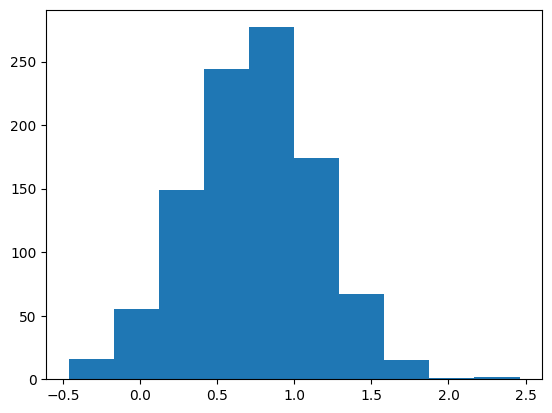

In [95]:

k=901

x_single = val_dataset[k,][0].to(device)
x_single = x_single.unsqueeze(0)  # becomes shape: (1, seq_len, d_model)
gmm = get_gmm_distribution(model, x_single)  # index defaults to 0

theta = val_dataset[k,][1]

samples = gmm.sample((1000,))

plt.hist(samples[:,1].cpu())
theta, samples.mean(0)

In [10]:
from torch.distributions import MultivariateNormal, Categorical, MixtureSameFamily
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

def test_mamba(sim, model, device, batch_size, theta_dim, num_samples=1000):
    # Load and prepare test data
    test_x = torch.load(f'test_sims/test_x_{sim}.pt')          # shape: (N, L)
    test_x = test_x.unsqueeze(-1) if test_x.ndim == 2 else test_x  # shape: (N, L, 1)
    test_theta = torch.load(f'test_sims/test_theta_{sim}.pt')  # shape: (N, d)

    test_dataset = TensorDataset(test_x, test_theta)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_samples = []

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            weights, means, L = model(inputs)  # shapes: (B, K), (B, K, d), (B, K, d, d)

            # Compute covariances from Cholesky
            covs = L @ L.transpose(-1, -2)  # (B, K, d, d)

            # Create batched multivariate normal and mixture
            mvn = MultivariateNormal(loc=means, covariance_matrix=covs)
            mix = Categorical(probs=weights)
            gmm = MixtureSameFamily(mix, mvn)

            # Sample from each posterior p(θ | x_i)
            samples = gmm.sample((num_samples,))  # (num_samples, B, d)
            all_samples.append(samples)           # list of (num_samples, B, d)

    # Concatenate across batches → (num_samples, N, d)
    all_samples = torch.cat(all_samples, dim=1)

    # Save and return
    torch.save(all_samples, f'test_sims/samples_{sim}_mamba_de_full.pt')
    return all_samples

for sim in ['WF', 'WF_DFE', 'WF_bottleneck']:
    samples = test_mamba(
        sim=sim,
        model=model,
        device='cuda:1',
        batch_size=100,
        theta_dim=2,     
        num_samples=1000
    )


Evaluating: 100%|██████████| 10/10 [00:00<00:00, 202.06it/s]
